# Transformer model for Time Series Forecasting

- 학습/테스트 데이터 동일 (과적합 가능성)
- Epoch 30, Loss: 0.0392

### Import libraries

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing sample time series data
(MinMaxScaler + window 적용)

In [2]:
# 1. 임의의 시계열 데이터 생성 (sin + noise)
np.random.seed(42)
t = np.arange(0, 500)
data = np.sin(0.05 * t) + 0.1 * np.random.randn(500)
data = data.reshape(-1, 1)  # shape: (400, 1)

# 2. MinMaxScaler로 정규화 (0~1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. 슬라이딩 윈도우 생성
def create_inout_sequences(data, input_window, output_window):
    in_seq, out_seq = [], []
    L = len(data)
    for i in range(L - input_window - output_window):
        train_seq = data[i:i+input_window]
        train_label = data[i+input_window:i+input_window+output_window]
        in_seq.append(train_seq)
        out_seq.append(train_label)
    return np.array(in_seq), np.array(out_seq)

input_window = 48
output_window = 24
X, y = create_inout_sequences(data_scaled, input_window, output_window)  # (N, 30, 1), (N, 10, 1)

# 4. Tensor로 변환
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # shape: (batch, input_window, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)  # shape: (batch, output_window, 1)

print("Input tensor shape:", X_tensor.shape)
print("Target tensor shape:", y_tensor.shape)


Input tensor shape: torch.Size([428, 48, 1])
Target tensor shape: torch.Size([428, 24, 1])


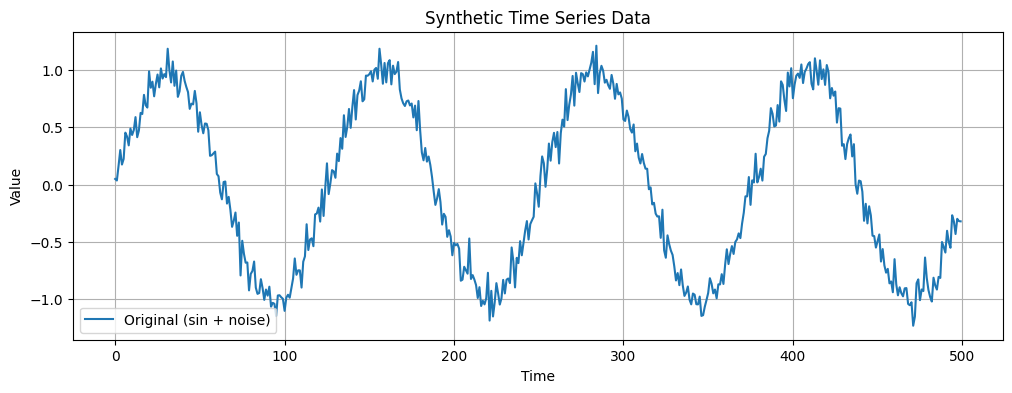

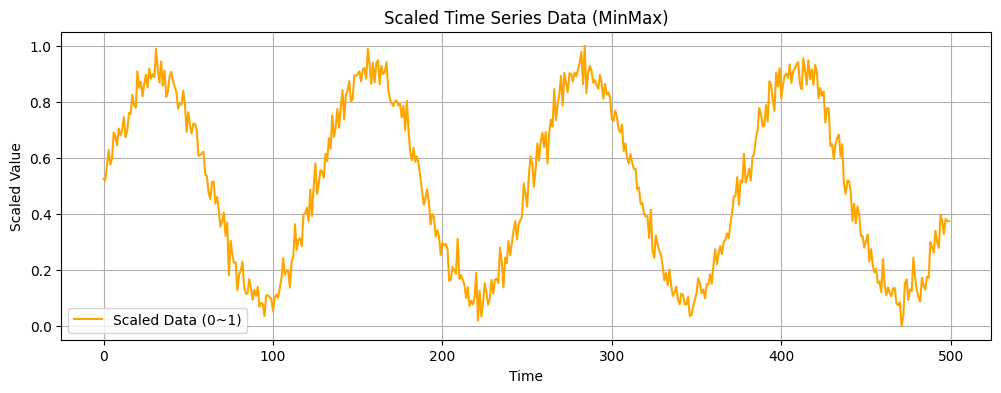

In [3]:
# 시계열 데이터 시각화 (정규화 전 원본)
plt.figure(figsize=(12, 4))
plt.plot(t, data, label="Original (sin + noise)")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# 시계열 데이터 시각화 (MinMaxScaler 적용 후)
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label="Scaled Data (0~1)", color='orange')
plt.title("Scaled Time Series Data (MinMax)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()

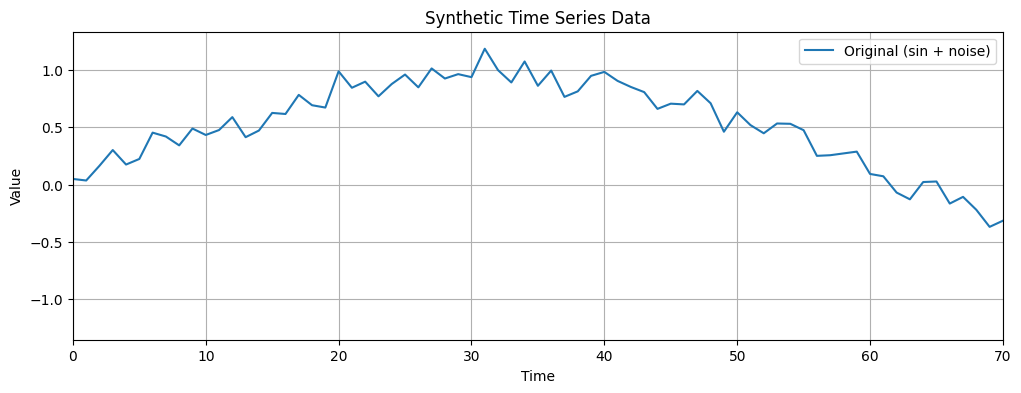

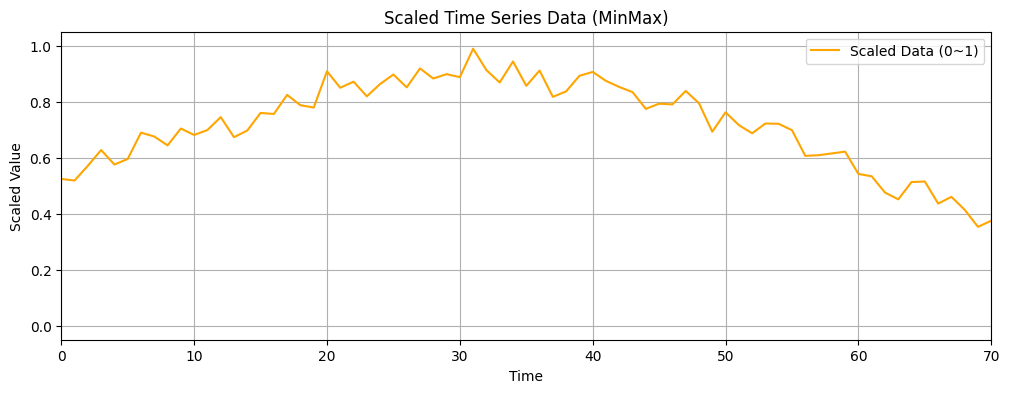

In [4]:
# 시계열 데이터 시각화 (정규화 전 원본)
plt.figure(figsize=(12, 4))
plt.plot(t, data, label="Original (sin + noise)")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim(0, 70)  # x축 범위 지정
plt.legend()
plt.grid(True)
plt.show()

# 시계열 데이터 시각화 (MinMaxScaler 적용 후)
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label="Scaled Data (0~1)", color='orange')
plt.title("Scaled Time Series Data (MinMax)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.xlim(0, 70)  # x축 범위 지정
plt.legend()
plt.grid(True)
plt.show()


### Embedding & Positional Encoding

In [5]:
# 임베딩 및 위치 인코딩
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 짝수
        pe[:, 1::2] = torch.cos(position * div_term)  # 홀수
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: (1, max_len, d_model)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]

# 실수 입력을 벡터 공간으로 표현해 패턴 인식 가능하게 함
class TimeSeriesEmbedding(nn.Module):
    def __init__(self, input_dim, d_model, max_len):
        super(TimeSeriesEmbedding, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)             # (batch, seq_len, d_model)
        x = self.pos_encoder(x)            # 위치 인코딩 추가
        return x


### Transformer model (Encoder-only)

In [6]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, output_window, dropout=0.1, max_len=500):
        super(TimeSeriesTransformer, self).__init__()

        # 1. 임베딩: 실수 시계열 입력 → d_model 차원 벡터 + 위치 인코딩
        self.embedding = TimeSeriesEmbedding(input_dim, d_model, max_len)

        # 2. Transformer Encoder 구성
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # 입력 순서: (batch, seq_len, d_model)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 3. 출력층: d_model → 예측할 output_window 길이 × output_dim
        self.decoder = nn.Linear(d_model, output_window)  # 각 시점에서 output_window 길이 예측

    def forward(self, x):
        # x: (batch, input_window, input_dim)
        x = self.embedding(x)            # → (batch, input_window, d_model)
        x = self.encoder(x)              # → (batch, input_window, d_model)

        # 여기선 모든 시점의 정보를 평균 내어 요약
        x = x.mean(dim=1)                # → (batch, d_model)

        x = self.decoder(x)              # → (batch, output_window)
        return x.unsqueeze(-1)           # → (batch, output_window, 1)


### Hyperparameter Setting and Model Initialization

In [7]:
# 하이퍼파라미터 설정
input_dim = 1             # 시계열 입력 차원 (스칼라)
output_dim = 1            # 출력 차원도 동일 (스칼라)
d_model = 64              # 임베딩 및 모델 차원
nhead = 4                 # 멀티헤드 어텐션 수 (d_model % nhead == 0)
num_layers = 3            # 인코더 레이어 수
dim_feedforward = 128     # FeedForward 내부 차원
dropout = 0.1             # 드롭아웃 비율
input_window = 48         # 과거 시점 수
output_window = 24        # 예측할 미래 시점 수
max_len = input_window    # 위치 인코딩 길이 = 입력 시퀀스 길이

# 모델 초기화
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    max_len=max_len
).to(device)

# 출력 확인
print(model)


TimeSeriesTransformer(
  (embedding): TimeSeriesEmbedding(
    (input_proj): Linear(in_features=1, out_features=64, bias=True)
    (pos_encoder): PositionalEncoding()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=24, bias=True)
)


### Training the model

In [8]:
# 손실 함수 (MAE) 및 옵티마이저 설정
criterion = nn.L1Loss()  # MAE
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터셋 준비
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 학습 루프
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()

        # 모델 예측
        output = model(xb)  # (batch, output_window, 1)

        # 손실 계산
        loss = criterion(output, yb)  # MAE

        # 역전파 및 파라미터 업데이트
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.3210
Epoch 2, Loss: 0.2470
Epoch 3, Loss: 0.1534
Epoch 4, Loss: 0.0677
Epoch 5, Loss: 0.0511
Epoch 6, Loss: 0.0457
Epoch 7, Loss: 0.0449
Epoch 8, Loss: 0.0423
Epoch 9, Loss: 0.0445
Epoch 10, Loss: 0.0403
Epoch 11, Loss: 0.0420
Epoch 12, Loss: 0.0421
Epoch 13, Loss: 0.0414
Epoch 14, Loss: 0.0433
Epoch 15, Loss: 0.0410
Epoch 16, Loss: 0.0394
Epoch 17, Loss: 0.0411
Epoch 18, Loss: 0.0399
Epoch 19, Loss: 0.0389
Epoch 20, Loss: 0.0399
Epoch 21, Loss: 0.0383
Epoch 22, Loss: 0.0393
Epoch 23, Loss: 0.0404
Epoch 24, Loss: 0.0378
Epoch 25, Loss: 0.0374
Epoch 26, Loss: 0.0379
Epoch 27, Loss: 0.0382
Epoch 28, Loss: 0.0377
Epoch 29, Loss: 0.0381
Epoch 30, Loss: 0.0393


### Transformer prediction -> Post-processing

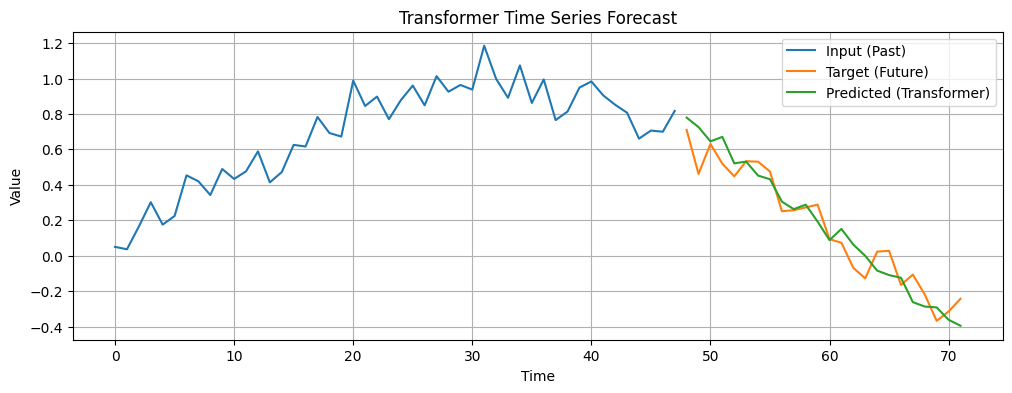

In [12]:
# 모델을 평가 모드로 전환
model.eval()

# 예측 결과 생성
with torch.no_grad():
    sample_input = X_tensor[0].unsqueeze(0)  # shape: (1, input_window, 1)
    prediction = model(sample_input)         # shape: (1, output_window, 1)

# 차원 정리
predicted = prediction.squeeze().cpu().numpy()  # shape: (output_window,)
actual = y_tensor[0].squeeze().cpu().numpy()    # shape: (output_window,)

# 정규화된 결과를 역변환 (0~1 → 원래 스케일)
input_original = scaler.inverse_transform(X_tensor[0].cpu().numpy())
target_original = scaler.inverse_transform(y_tensor[0].cpu().numpy())
predicted_original = scaler.inverse_transform(prediction.squeeze(0).cpu().numpy())

# 시각화
plt.figure(figsize=(12, 4))
plt.plot(range(input_window), input_original, label='Input (Past)')
plt.plot(range(input_window, input_window + output_window), target_original, label='Target (Future)')
plt.plot(range(input_window, input_window + output_window), predicted_original, label='Predicted (Transformer)')
plt.title("Transformer Time Series Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# save and show
plt.savefig("sin_result/Transformer_sin_function_forecast.png", bbox_inches='tight')
plt.show()

### END